In [1]:
from itertools import product
from collections import defaultdict

from qtranspiler.architectures import Grid
from qtranspiler.routing.algorithms import approx_token_swapping
from qtranspiler.routing.grid_routing import grid_route, grid_route_two_directions
from qtranspiler.utils import blocked_random_map, local_random_permutations, random_map, profile_func

from matplotlib import pyplot as plt

num_runs = 3

algorithms = (grid_route, grid_route_two_directions)
mapping_functions = (blocked_random_map, local_random_permutations, random_map)
locality = (True, False)

combinations = product(algorithms, mapping_functions, locality)


def is_local(locality):
    if locality:
        return 'local'
    return 'nonlocal'

def get_algorithm_name(algorithm):
    if not callable(algorithm):
        raise TypeError(f"{algorithm} is not a callable")
    if 'grid_route' == algorithm.__name__:
        return "Grid Route"
    elif 'grid_route_two_directions' == algorithm.__name__:
        return "Grid Route in 2 Directions"
    else:
        raise ValueError(f"Unknown Algorithm: {algorithm}")


# for algo, mapping, local in combinations:
#     print(get_algorithm_name(algo))
#     print(mapping)
#     print(is_local(local))


In [2]:
# Generate Grids

grid_dimensions = [(4, 4), (8, 4), (8, 8), (16, 4), (16, 8), (16, 16), (32, 8),
                   (32, 16), (64, 8), (24, 24), (32, 24), (32, 32), (64, 16)]

block_sizes = [(2, 2), (2, 2), (2, 2), (4, 2), (4, 4), (4, 4), (4, 4), (4, 4),
               (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]

grids = [Grid(*grid) for grid in grid_dimensions]

# for g, b in zip(grid_dimensions, block_sizes):
#     print(f"{g} in blocks of {b}")

In [3]:
# Generate Maps

def new_labels(algorithm, grids, block_sizes=None):
    if algorithm is local_random_permutations:
        return [
            local_random_permutations(grid, block[0] * block[1], *block)
            for grid, block in zip(grids, block_sizes)
        ]
    elif algorithm is blocked_random_map:
        return [
            blocked_random_map(grid, *block)
            for grid, block in zip(grids, block_sizes)
        ]
    else:
        return [random_map(grid) for grid in grids]


In [4]:
# Run Grid Routing

runs = defaultdict()
for algorithm, mapping, locality in combinations:
    key = (get_algorithm_name(algorithm), mapping, is_local(locality))
    print(key)
    runs[key] = [
        profile_func(algorithm,
                     num_runs,
                     g.numpy_array(),
                     new_label,
                     local=locality)
        for g, new_label in zip(grids, new_labels(mapping, grids, block_sizes))
    ]


('Grid Route', <function blocked_random_map at 0x7f235bb73f70>, 'local')
('Grid Route', <function blocked_random_map at 0x7f235bb73f70>, 'nonlocal')
('Grid Route', <function local_random_permutations at 0x7f2291191430>, 'local')
('Grid Route', <function local_random_permutations at 0x7f2291191430>, 'nonlocal')
('Grid Route', <function random_map at 0x7f22911914c0>, 'local')
('Grid Route', <function random_map at 0x7f22911914c0>, 'nonlocal')
('Grid Route in 2 Directions', <function blocked_random_map at 0x7f235bb73f70>, 'local')
('Grid Route in 2 Directions', <function blocked_random_map at 0x7f235bb73f70>, 'nonlocal')
('Grid Route in 2 Directions', <function local_random_permutations at 0x7f2291191430>, 'local')
('Grid Route in 2 Directions', <function local_random_permutations at 0x7f2291191430>, 'nonlocal')
('Grid Route in 2 Directions', <function random_map at 0x7f22911914c0>, 'local')
('Grid Route in 2 Directions', <function random_map at 0x7f22911914c0>, 'nonlocal')


In [14]:
# Approximate Token Swap
num_runs = 3
for map_ in mapping_functions:
    key = (approx_token_swapping.__name__, map_, '')
    print(key)
    runs[key] = [
        profile_func(approx_token_swapping,
                     num_runs,
                     g,
                     new_label.flatten())
        for g, new_label in zip(grids, new_labels(map_, grids, block_sizes))
    ]
# approx_token_swapping_runs = [
#     profile_func(approx_token_swapping, num_runs, g, new_label.flatten())
#     for g, new_label in zip(grids, new_labels)
# ]

('approx_token_swapping', <function blocked_random_map at 0x7f235bb73f70>, '')
('approx_token_swapping', <function local_random_permutations at 0x7f2291191430>, '')
('approx_token_swapping', <function random_map at 0x7f22911914c0>, '')


<Figure size 432x288 with 0 Axes>

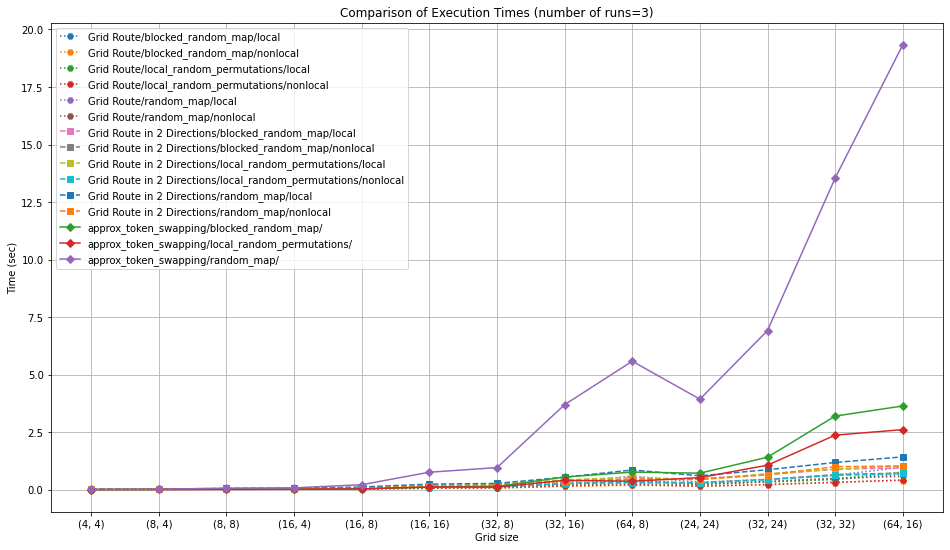

In [27]:
# Plot Times

plt.figure(1)
plt.figure(figsize=(16, 9))
sizes = [str(g.shape) for g in grids]

for key, value in runs.items():
    if key[0] == 'approx_token_swapping':
        marker = '-D'
    elif key[0] == "Grid Route":
        marker = ':H'
    else:
        marker = '--s'
    algorithm = key[0]
    mapping_function = key[1].__name__
    locality = key[2]
    timings = [run.average_time() for run in value]
    plt.plot(sizes,
             timings,
             marker,
             label=f'{algorithm}/{mapping_function}/{locality}')

plt.legend()
plt.grid(True)
plt.xlabel('Grid size')
plt.ylabel('Time (sec)')
plt.title(f'Comparison of Execution Times (number of runs={num_runs})')
plt.show()
# plt.savefig(f"times.png")


<Figure size 432x288 with 0 Axes>

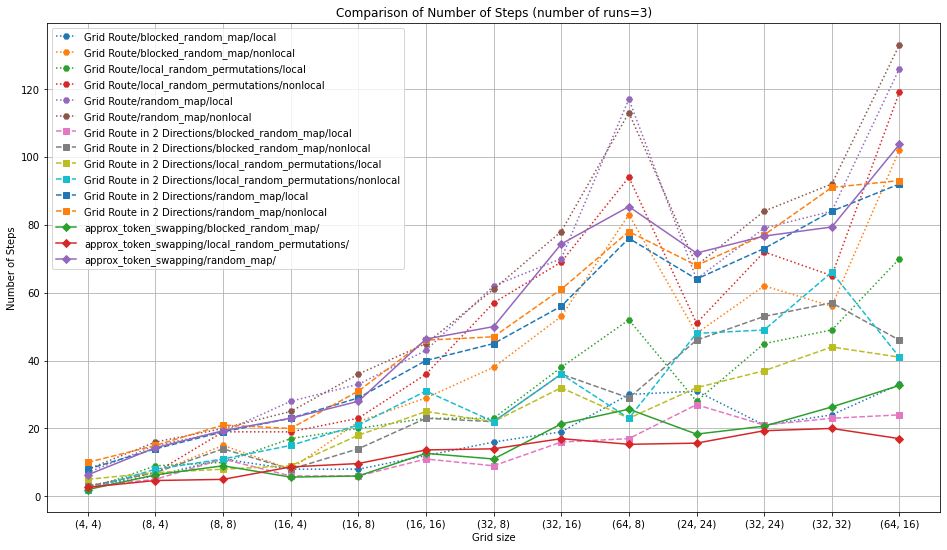

In [26]:
# Plot Steps

plt.figure(3)
plt.figure(figsize=(16, 9))
sizes = [str(g.shape) for g in grids]

for key, value in runs.items():

    if key[0] == 'approx_token_swapping':
        marker = '-D'
    elif key[0] == "Grid Route":
        marker = ':H'
    else:
        marker = '--s'
    algorithm = key[0]
    mapping_function = key[1].__name__
    locality = key[2]
    num_steps = [run.average_value(len) for run in value]
    plt.plot(sizes,
            num_steps,
            marker,
            label=f'{algorithm}/{mapping_function}/{locality}')

plt.legend()
plt.grid(True)
plt.xlabel('Grid size')
plt.ylabel('Number of Steps')
plt.title(f'Comparison of Number of Steps (number of runs={num_runs})')
plt.show()
# plt.savefig(f"steps.png")
